# Text Classifiers:
#### This notebook contains various classifiers that can be used on a provided text dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

import nltk
import tensorflow as tf
import keras
import sklearn
import csv

Using TensorFlow backend.


In [2]:
import itertools
import matplotlib.pyplot as plt
from sklearn import svm, datasets

## This function is called by the classifiers to provide a visulization of the results
def plot_confusion_matrix(cm, classes, Y_test,
                          predictions,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print("Confusion Matrix:")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    print(classification_report(Y_test, predictions, target_names = classes))
    print("True Negative:", cm[0][0])
    print("False Negative:", cm[1][0])
    print("True Positive:", cm[1][1])
    print("False Positive:", cm[0][1])

### Complete -> Enter the name of the dataset you want to test into the file_in variable:
##### The file_out dataset is the name of the dataset that will stored the number converted version of the text data. Set the name of file_out to the name of the converted dataset if you already have a dataset that has numeric representations of the dataset already instead of words. Otherwise, file_out will be the output file name that is the converted data of the file_in dataset that gets read in for classification for the tensorflow model. Also, if you already have a converted file, make sure that re_read is set to 0 so that it does not get overwritten.

In [5]:
### Enter filenames below:
file_in = "problems_expertiza_all.csv"
file_out = "problems_expertiza_all_converted.csv"
### Enter column names for data and labels below:
data_col = "Comments"
label_col = "Mentions_Problem"
### Set re_read to 0 if you already have a converted text file, 1 if it needs to be created
re_read = 0

In [6]:
df = pd.read_csv(file_in, engine = 'python');
print(file_in)
print(df.dtypes)
print("Sample size:", len(df))
print(df.head(5))

problems_expertiza_all.csv
Mentions_Problem     int64
Comments            object
dtype: object
Sample size: 14609
   Mentions_Problem                                           Comments
0                 1                                      Yes it works.
1                 1                      Test Plan section is missing.
2                 1  The write up contains clear explanation to wha...
3                 1  The Wiki page did not have a test plan. Howeve...
4                 1  There was no link to the test plan, so I could...


#### Setting up the data.

In [5]:
X = df[data_col]
Y = df[label_col]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.1, random_state=42)
print("Train data amount:", len(X_train))
print("Test data amount:", len(X_test))

Train data amount: 13148
Test data amount: 1461


In [9]:
### Stemming somtimes improves performance
# from nltk.stem import *
# stemmer = PorterStemmer()
# new_xtr = []
# new_xte = []
# for sent in X_train:
#     sent = nltk.word_tokenize(sent)
#     sent = [stemmer.stem(w) for w in sent]
#     sent = " ".join(sent)
#     new_xtr.append(sent)
# X_train = new_xtr
# for sent in X_test:
#     sent = nltk.word_tokenize(sent)
#     sent = [stemmer.stem(w) for w in sent]
#     sent = " ".join(sent)
#     new_xte.append(sent)
# X_test = new_xte

In [156]:
### Might improve performance on Keras Model (try this)
from nltk.tokenize import RegexpTokenizer
import string
tokenizer = RegexpTokenizer(r'\w+')
table = str.maketrans('', '', string.punctuation)
new_xtr = []
new_xte = []
for sent in X_train:
    sent = sent.split()
    sent = [w.translate(table) for w in sent]
    sent = " ".join(sent)
    sent = str.lower(sent)
    new_xtr.append(sent)
X_train = new_xtr
for sent in X_test:
    sent = sent.split()
    sent = [w.translate(table) for w in sent]
    sent = " ".join(sent)
    sent = str.lower(sent)
    new_xte.append(sent)
X_test = new_xte
all_data = X_train + X_test

In [203]:
### Stemming somtimes improves performance
from nltk.stem import *
stemmer = PorterStemmer()
new_xtr2 = []
new_xte2 = []
for sent in X_train:
    sent = nltk.word_tokenize(sent)
    sent = [stemmer.stem(w) for w in sent]
    sent = " ".join(sent)
    new_xtr2.append(sent)
X_train = new_xtr2
for sent in X_test:
    sent = nltk.word_tokenize(sent)
    sent = [stemmer.stem(w) for w in sent]
    sent = " ".join(sent)
    new_xte2.append(sent)
X_test = new_xte2
all_data = X_train + X_test

## Rule-based classifier:


In [206]:
#### Rule Approach
## Uses nltk pos-tagging to label words
loop = 0
count = 0
numComments = 0
suggestions_per_comment = []
end = len(df)
labels = []
predictions = []
for loop in range(end):
    comment = df[data_col][loop]
    comment = all_data[loop]
    prompt = df[label_col][loop]
#     #### Uncomment below condition only when using suggestions_data_balanced.csv ####
    if isinstance(comment, str) == False:
        continue
#     ####
    sentTok = nltk.sent_tokenize(comment)
    modalVerb = False
    foundSuggestion = False
    for sentence in sentTok:
        wordTok = nltk.word_tokenize(sentence)
        words = nltk.pos_tag(wordTok)
        for word in words:
            if word[1] == "MD":
                modalVerb = True
                continue
            elif word[1] == "VB" or word[1] == "VBZ" or word[1] == "VBP":
                if modalVerb:
                    count += 1
                    foundSuggestion = True
                    break
            elif word[1] == ".":
                phraseList = {"have more", "suggestion", "perhaps", "better if"}
                endSentence = False
                for phrase in phraseList:
                    if (phrase in comment):
                        count += 1
                        foundSuggestion = True
                        endSentence = True
                        break
                if endSentence:
                    break
            modalVerb = False
        if (foundSuggestion):
            break
    actual = df[label_col][loop]
    if (foundSuggestion):
        predictions.append(1)
    else:
        predictions.append(0)
    if (actual == '1' or actual == 1.0):
        labels.append(1)
    else:
        labels.append(0)
    count = 0

Confusion Matrix:
[[1107  832]
 [1124  815]]
             precision    recall  f1-score   support

      False       0.50      0.57      0.53      1939
       True       0.49      0.42      0.45      1939

avg / total       0.50      0.50      0.49      3878

True Negative: 1107
False Negative: 1124
True Positive: 815
False Positive: 832


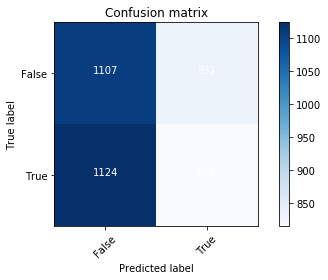

In [208]:
## Graphical visualization
cnf_matrix = confusion_matrix(labels, predictions)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = labels, predictions = predictions,
                      title='Confusion matrix')

## Multinomial Naive Bayes classifier:

In [7]:
#### Multinomial Naive Bayes !!! STEMMING IMPROVES 2% !!!
# text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
text_clf = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB()),
])

In [8]:
text_clf = text_clf.fit(X_train,Y_train)

In [9]:
predicted = text_clf.predict(X_test)
accuracy = np.mean(predicted == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted)
print(cm)

Accuracy: 0.783025325119781
[[501 205]
 [112 643]]


Confusion Matrix:
[[501 205]
 [112 643]]
             precision    recall  f1-score   support

      False       0.82      0.71      0.76       706
       True       0.76      0.85      0.80       755

avg / total       0.79      0.78      0.78      1461

True Negative: 501
False Negative: 112
True Positive: 643
False Positive: 205


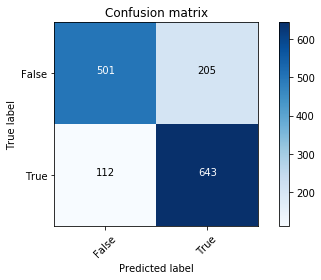

In [10]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted,
                      title='Confusion matrix')

## Support Vector Machine classifier:

In [11]:
#### Support Vector Machine !!! STEMMING REDUCES 2% !!!
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge',
                                                  penalty='l2',
                                                  max_iter=5,
                                                  random_state=42)), 
                    ])

In [12]:
_ = text_clf_svm.fit(X_train,Y_train)

In [13]:
predicted_svm = text_clf_svm.predict(X_test)
accuracy = np.mean(predicted_svm == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8350444900752909


Confusion Matrix:
[[557 149]
 [ 92 663]]
             precision    recall  f1-score   support

      False       0.86      0.79      0.82       706
       True       0.82      0.88      0.85       755

avg / total       0.84      0.84      0.83      1461

True Negative: 557
False Negative: 92
True Positive: 663
False Positive: 149


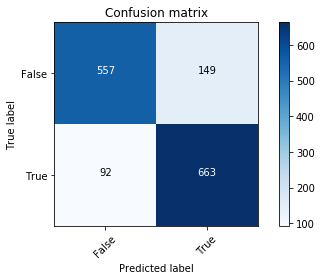

In [14]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_svm)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted_svm,
                      title='Confusion matrix')

## Gridsearch classifier:

In [15]:
#### Gridsearch
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
    }

In [16]:
## Can use on previous svm or bayes classifier
gs_clf = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train,Y_train)
predicted_gs = gs_clf.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

In [17]:
print("Grid search best score:", gs_clf.best_score_)
print(gs_clf.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.8197444478247642
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Accuracy: 0.8186173853524983


Confusion Matrix:
[[537 169]
 [ 96 659]]
             precision    recall  f1-score   support

      False       0.85      0.76      0.80       706
       True       0.80      0.87      0.83       755

avg / total       0.82      0.82      0.82      1461

True Negative: 537
False Negative: 96
True Positive: 659
False Positive: 169


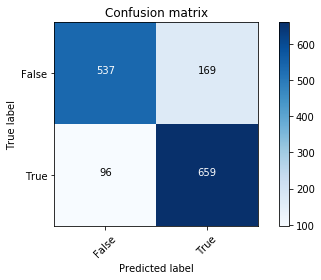

In [18]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Combined Scores of Above

In [19]:
## Ensemble classification
# p1 = predictions
p2 = predicted
p3 = predicted_svm
p4 = predicted_gs
pall = []
p_test = []
# print(len(p2))
# print(len(p3))
# print(len(p4))
for i in range(len(p2)):
    if p2[i] == 0:
        p2[i] = -1
    if p3[i] == 0:
        p3[i] = -1
    if p4[i] == 0:
        p4[i] = -1
for i in range(len(p2)):
    lab = p2[i] + p3[i] + p4[i]
    if lab >= 0:
        lab = 1
    else:
        lab = 0
    pall.append(lab)

Confusion Matrix:
[[542 164]
 [ 97 658]]
             precision    recall  f1-score   support

      False       0.85      0.77      0.81       706
       True       0.80      0.87      0.83       755

avg / total       0.82      0.82      0.82      1461

True Negative: 542
False Negative: 97
True Positive: 658
False Positive: 164


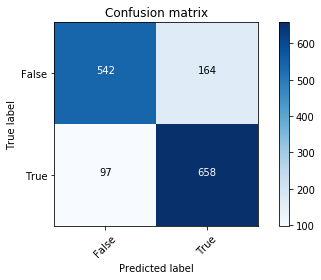

In [20]:
cnf_matrix = confusion_matrix(Y_test, pall)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = Y_test, predictions = pall,
                      title='Confusion matrix')

## Tensorflow/Keras Classifier

#### Create a numeric version of this text data set if not present (uncomment below if to do so). Also determines length of vocabulary to use for embedding layer size:

In [7]:
# Create the word mappings
def bagofwords():
    num_data = len(df)
    a = []
    loop = 0
    for loop in range(num_data):
        if (loop % 50000 == 0): # For larger datasets
            print("Update:", loop) # Check spot in dictionary creator
        comment = df[data_col][loop]
        sentTok = nltk.sent_tokenize(comment)
        for sentence in sentTok:
            a.append(sentence)    
    a = (' '.join(a)).lower()
    text = nltk.word_tokenize(a)
    newset = set()
    for word in text:
        newset.add(word)
    # Fill in found words
    word_to_ix = { w:(i+4) for i,w in enumerate(sorted(newset)) }
    ix_to_word = { (i+4):w for i,w in enumerate(sorted(newset)) }
    # Fill in reserved values
    ix_to_word[0] = "<PAD>"
    ix_to_word[1] = "<START>"
    ix_to_word[2] = "<UNK>"
    ix_to_word[3] = "<UNUSED>"
    word_to_ix["<PAD>"] = 0 # Used to equalize text length
    word_to_ix["<START>"] = 1
    word_to_ix["<UNK>"] = 2  # unknown value
    word_to_ix["<UNUSED>"] = 3
    return word_to_ix, ix_to_word

In [8]:
word_to_ix, ix_to_word = bagofwords()
# print(ix_to_word[3853])
# print(word_to_ix["please"]) # Ensure word is in dictionary
print("Size of vocabulary:", len(ix_to_word))

Update: 0
Size of vocabulary: 12190


##### An update text will be printed in order to keep track of the conversion process.

In [29]:
## Convert original data to number representations
if (re_read == 1):
    num_data = len(df)
    loop = 0
    converted_text_data = []
    print("Total to print:", num_data)
    for loop in range(num_data):
        if (loop % 50000 == 0): # For larger datasets
            print("Update:", loop) # Check spot in converter
        comment = df[data_col][loop]
        if isinstance(comment, str) == False: # Skip missing text from dataset if present
            continue
        comment = comment.lower()
        text = nltk.word_tokenize(comment)
        length = len(text)
        i = 0
        for i in range(length):
            try:
                text[i] = word_to_ix[text[i]]
            except KeyError:
                text[i] = 2 # Unknown mapping
        text = [int(i) for i in text]
        converted_text_data.append(text)

In [30]:
if (re_read == 1):
    with open(file_out, 'w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerow([data_col, label_col])
        i = 0
        for i in range(num_data):
            if (i % 50000 == 0): # For larger datasets
                print("Update:", i) # Check spot in converter
            rev = converted_text_data[i]
            label = df[label_col][i]
            if (label != 1):
                label = 0
            writer.writerow([rev, label])

In [31]:
if (re_read == 1):
    print(len(df))
    print(len(converted_text_data))

#### Read in the converted text to number dataset, shuffle data, and run the classifier:

In [9]:
df = pd.read_csv(file_out, engine = 'python');
print(file_out)
print(df.dtypes)
np.random.seed(42) # Keep permutation assortment the same
df = df.iloc[np.random.permutation(len(df))]
df = df.reset_index(drop=True)
print("Sample size:", len(df))

problems_expertiza_all_converted.csv
Comments            object
Mentions_Problem     int64
dtype: object
Sample size: 14609


In [10]:
## Parses the integer list data from file into a proper integer list for the classifier
full_data = []
for dat in df[data_col]:
    paragraph = []
    sentence = []
    for letter in dat:
        if (letter == '[' or letter == ']' or letter == ' '):
            continue
        elif (letter == ','):
            sentence = (''.join(sentence))
            paragraph.append(sentence)
            sentence = []
        else:
            sentence.append(letter)
    paragraph = [int(i) for i in paragraph]
    full_data.append(paragraph)
print("Dataset length:", len(full_data))

Dataset length: 14609


In [11]:
## Initialize train and test data, train and test labels
num_data = len(df)
num_train = int(num_data * 0.9) # df.head this amount
num_test = int(num_data - num_train) # df.tail this amount
train_data = full_data[:num_train]
test_data = full_data[num_train:]
train_labels = df[label_col].head(num_train) # is_prompt_exists
test_labels = df[label_col].tail(num_test)
print("Number train data:", len(train_data))
print("Number test data:", len(test_data))

Number train data: 13148
Number test data: 1461


In [12]:
## Find the maximum sentence length to use for padding training data
maxlength = 0
data_lengths = []
for i in range(len(full_data)):
    data_lengths.append(len(full_data[i]))
    maxlength = max(len(full_data[i]), maxlength)
#     if maxlength > 4000:
#         print(i)
print("Max text length:", maxlength)
print("Average text length:", np.average(data_lengths))
print("Median text length:", np.median(data_lengths))

Max text length: 1344
Average text length: 33.45779998630981
Median text length: 24.0


In [13]:
numabove = 0
for i in range(len(data_lengths)):
    if (data_lengths[i] > 300):
        numabove = numabove + 1
print(len(data_lengths))
print(numabove)
maxlengths = 250 # Create a function later to determine based on proportion
maxlength = 300 #### Changed

14609
3


In [14]:
## Pad the words to standardized text array length
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_to_ix["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlength)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_to_ix["<PAD>"],
                                                      padding='post',
                                                      maxlen=maxlength)

In [15]:
## Initiate validation sets
val_size = int(num_train * 0.9) # Set apart 10% of train data for validation

x_val = train_data[:num_train-val_size]
partial_x_train = train_data[num_train-val_size:]

y_val = train_labels[:num_train-val_size]
partial_y_train = train_labels[num_train-val_size:]

print("Training data length:", len(partial_x_train))
print("Validation data length:",len(x_val))

Training data length: 11833
Validation data length: 1315


In [21]:
## Create the model
import operator # Finding vocabulary length, max dictionary index + 1
vocab_size = max(ix_to_word.items(), key=operator.itemgetter(1))[0] + 1
print("Vocabulary size:", vocab_size)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 32))
model.add(keras.layers.Conv1D(32,2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=(16))))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.GlobalAveragePooling1D())
# model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Vocabulary size: 12190
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          390080    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 398,465
Trainable params: 398,465
Non-trainable params: 0
_______________________________________________

In [22]:
## Configured model with optimizer and loss function
model.compile(optimizer = tf.train.AdamOptimizer(),
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

In [23]:
## Train the model
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=5,
                   batch_size=125,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 11833 samples, validate on 1315 samples
Epoch 1/5
11833/11833 [==============================] - 37s 3ms/step - loss: 0.6041 - acc: 0.6658 - val_loss: 0.4561 - val_acc: 0.7924
Epoch 2/5
11833/11833 [==============================] - 35s 3ms/step - loss: 0.4252 - acc: 0.8246 - val_loss: 0.4233 - val_acc: 0.8198
Epoch 3/5
11833/11833 [==============================] - 36s 3ms/step - loss: 0.3647 - acc: 0.8618 - val_loss: 0.4280 - val_acc: 0.8236
Epoch 4/5
11833/11833 [==============================] - 35s 3ms/step - loss: 0.3252 - acc: 0.8809 - val_loss: 0.4305 - val_acc: 0.8236
Epoch 5/5
11833/11833 [==============================] - 34s 3ms/step - loss: 0.3036 - acc: 0.8895 - val_loss: 0.4469 - val_acc: 0.8160


In [84]:
# Mask: 708537/708537 [==============================] - 297s 420us/step - loss: 0.6572 - acc: 0.6442 - val_loss: 0.5878 - val_acc: 0.7003
# No-Mask: 708537/708537 [==============================] - 281s 397us/step - loss: 0.6633 - acc: 0.6286 - val_loss: 0.5946 - val_acc: 0.7131

In [69]:
## Evaluate the model
predicted_nn = model.predict_classes(test_data)
results = model.evaluate(test_data, test_labels)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

785/785 [==============================] - 0s 23us/step
Test loss: 0.4532169457453831
Test accuracy: 0.8178343952841061


Confusion Matrix:
[[336  76]
 [ 67 306]]
             precision    recall  f1-score   support

      False       0.83      0.82      0.82       412
       True       0.80      0.82      0.81       373

avg / total       0.82      0.82      0.82       785

True Negative: 336
False Negative: 67
True Positive: 306
False Positive: 76


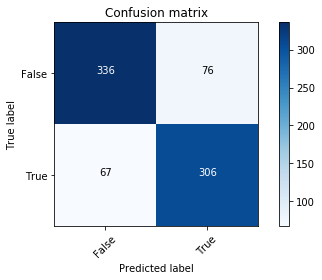

In [70]:
## Graphical visualization
cnf_matrix = confusion_matrix(test_labels, predicted_nn)
plt.figure()
class_names = ['False, True']
plot_confusion_matrix(cnf_matrix, classes=['False', 'True'],
                      Y_test = test_labels, predictions = predicted_nn,
                      title='Confusion matrix')

In [68]:
## Save the model for future reference
# model.save('politness_chromium_1A.h5')

In [69]:
# new_model = keras.models.load_model(Insert File Name Here)
# new_model.summary()

In [70]:
# new_model.compile(optimizer = tf.train.AdamOptimizer(),
#              loss = 'binary_crossentropy',
#              metrics=['accuracy'])
# loss2, acc2 = new_model.evaluate(test_data, test_labels)
# print("Loss:", loss2)
# print("Accuracy:", acc2)

In [71]:
## Graph the data
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

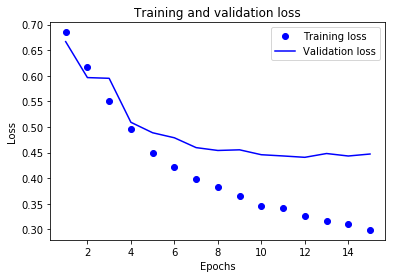

In [72]:
## Visualize training and validation loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

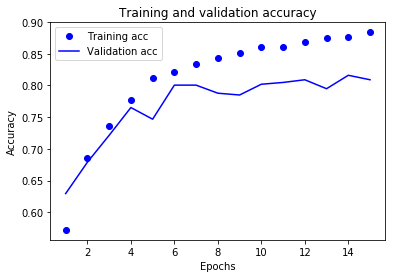

In [73]:
## Visualize training and validation accuracy
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Citation for parts of keras model
#@title MIT License
'#
'# Copyright (c) 2017 François Chollet
'#
'# Permission is hereby granted, free of charge, to any person obtaining a
'# copy of this software and associated documentation files (the "Software"),
'# to deal in the Software without restriction, including without limitation
'# the rights to use, copy, modify, merge, publish, distribute, sublicense,
'# and/or sell copies of the Software, and to permit persons to whom the
'# Software is furnished to do so, subject to the following conditions:
'#
'# The above copyright notice and this permission notice shall be included in
'# all copies or substantial portions of the Software.